### 함수 저장소

1. 학습 데이터셋 비교 가시화

visualize_multiple_dataloaders([test_loader], test_loader, images_per_loader=5)

2. 실험 진행용 학습모델 저장

### 1. 라이브러리 불러오기

In [1]:
import os
import shutil
import random
from torch.utils.data import DataLoader
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gc


import torchvision
from torchvision.datasets import CIFAR10
from torchvision.datasets import CIFAR100
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
from torchvision import transforms


# Visualization
import cv2
import matplotlib.pyplot as plt
from torchsummary import summary

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### Neural Network Master Switch Board

In [ ]:
# Neural Network Retrain Option
#모델/데이터 전체 리셋
Data_Reset = False
#학습된 모델 없등면 자동으로 학습
Auto_Init = True
defualt_epoch = 2
#Model Save Path
default_path = "default_path"
#로그 기록 여부
log_save = True
## Switch Baord based on stage
poision_sys_reset = False
restore_sys_reset = False
reclass_sys_reset = False
multiplier_sys_reset = False
##Muliplier_sys_reset by Type
M_reset_auto_10 =False
M_reset_unet_10 =False
M_reset_auto_attacked =False
M_reset_unet_attacked =False
M_reset_auto_100 =False
M_reset_unet_100 =False

##### Automated Git Ignore 

In [4]:
def gitignore(directory = default_path, gitignore_path=".gitignore"):

    # .gitignore 파일이 존재하는지 확인
    if not os.path.exists(gitignore_path):
        print(f"{gitignore_path} 파일이 존재하지 않습니다. 새로 생성합니다.")
        with open(gitignore_path, 'w') as f:
            f.write("")  # 빈 .gitignore 파일 생성
    
    # .gitignore 파일을 읽기
    with open(gitignore_path, 'r') as f:
        lines = f.readlines()

    # 이미 디렉토리가 .gitignore에 있는지 확인
    ignore_line = f"{directory}/\n"
    if ignore_line not in lines:
        # 디렉토리가 없으면 추가
        with open(gitignore_path, 'a') as f:
            f.write(ignore_line)
        print(f"{directory} 디렉토리를 .gitignore에 추가했습니다.")
    else:
        print(f"{directory} 디렉토리가 이미 .gitignore에 존재합니다.")


### 2. 데이터셋 정의 - 비오염

In [5]:
# Data loading and transformations
transform = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  transforms.RandomCrop(32, padding=4),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
# Use PyTorch's torchvision.transforms.ToTenesor() to convert the dataset to tensor format
train_set = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = CIFAR10(root='./data', train=False, download=True, transform=transform)
add_set = CIFAR100(root='./data', train=True, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Use PyTorch's DataLoader to divide the dataset into mini-batches and load the data
train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=64, shuffle=False)
add_loader = DataLoader(dataset=add_set, batch_size=64, shuffle=False)

In [8]:
def visualize_multiple_dataloaders(dataloaders, trainloader, images_per_loader=5):
    num_loaders = len(dataloaders)
    classes = trainloader.dataset.classes

    # 플롯 크기 설정
    plt.figure(figsize=(8,8))

    for i, loader in enumerate(dataloaders):
        # 각 DataLoader에서 배치 하나 가져오기
        batch = next(iter(loader))
        if len(batch) == 2:
            images, labels = batch
        elif len(batch) == 4:\
            _ , _, images, labels = batch
        images = torch.clamp(images, 0, 1)  # 이미지를 0과 1 사이로 클리핑하여 표시 문제 방지

        # 각 DataLoader에서 선택한 이미지 수만큼 시각화
        for j in range(images_per_loader):
            idx = i * images_per_loader + j
            plt.subplot(num_loaders, images_per_loader, idx + 1)
            plt.imshow(images[j].permute(1, 2, 0))  # 이미지 차원 변경: (C, H, W) -> (H, W, C)
            plt.title(classes[labels[j].item()])
            plt.axis('off')

    plt.tight_layout()
    plt.show()

### 3. 신경망 코딩

#### 3.1. ResNet50

In [9]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

#### 3.2. Autoencoder 모델 정의

In [10]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder 부분
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),   # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # 8x8 -> 4x4
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128)  # latent space (압축된 표현)
        )
        
        # Decoder 부분
        self.decoder = nn.Sequential(
            nn.Linear(128, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),   # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),     # 16x16 -> 32x32
            nn.Tanh()  # 0~1 범위로 출력
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#### 3.3. U-Net 모델 정의

In [11]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # 인코더 (Contracting Path)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 32x32 -> 16x16
        )
        
        self.encoder_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 16x16 -> 8x8
        )
        
        self.encoder_3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 8x8 -> 4x4
        )

        # 병목층 (Bottleneck)
        self.bottleneck = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # 디코더 (Expanding Path)
        self.decoder_1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest')  # 4x4 -> 8x8
        )
        
        self.decoder_2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest')  # 8x8 -> 16x16
        )
        
        self.decoder_3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest')  # 16x16 -> 32x32
        )
        
        # 최종 출력 레이어
        self.final_conv = nn.Conv2d(64, 3, kernel_size=3, padding=1)  # 출력 채널 3 (RGB 이미지)

    def forward(self, x):
        # 인코더
        enc1 = self.encoder(x)
        enc2 = self.encoder_2(enc1)
        enc3 = self.encoder_3(enc2)
        
        # 병목층
        bottleneck = self.bottleneck(enc3)
        
        # 디코더
        dec1 = self.decoder_1(bottleneck)
        dec2 = self.decoder_2(dec1)
        dec3 = self.decoder_3(dec2)
        
        # 최종 출력
        out = self.final_conv(dec3)
        return out


### 4. 신경망 학습과 테스트 진행

#### Generic Train and evaluate function

In [ ]:
# Train and evaluate function
def train_and_evaluate(model, train_loader, test_loader, device = device, epochs=defualt_epoch, \
                       Data_Reset = Data_Reset, net_reset = False, folder_path = default_path, \
                       net_name = "defual_net.pt", log_save = log_save, log_name = "default_log"):
  
  if os.path.exists(folder_path)== False:
    print("디렉토리 없음")
    if net_reset == False and Data_Reset == False and Auto_Init == False:
      return
  
    os.mkdir(folder_path)
    print("디렉토리를 만들었습니다 : ", folder_path)
    gitignore(directory = folder_path)
  
  os.chdir(folder_path)

  if os.path.exists(net_name) == False and Auto_Init == False:
      print("학습데이터 없음")
      os.chdir("../")
      return

  if net_reset == True or Data_Reset == True or (os.path.exists(net_name) == False and Auto_Init == True):

    model.train()

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=1e-4)

    accuracies = []

    # DataLoader에서 데이터 항목 개수 확인
    for batch in train_loader:
        num_items = len(batch)  # 배치에서 항목 개수 확인
        print("Number of Data Type:", num_items)
        break

    for epoch in range(epochs):
      running_loss = 0.0

      if num_items == 2:
        for data in train_loader:
            original_images, original_labels = data
            original_images, original_labels = original_images.to(device), original_labels.to(device)

            optimizer.zero_grad()

            outputs = model(original_images)
            loss = criterion(outputs, original_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
      
      elif num_items == 4:
        for data in train_loader:
            _, _, poisoned_images, poisoned_labels = data
            poisoned_images, poisoned_labels = poisoned_images.to(device), poisoned_labels.to(device)

            optimizer.zero_grad()

            # 모델 예측
            outputs = model(poisoned_images)

            # 손실 계산
            loss = criterion(outputs, poisoned_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
      elif num_items == 5:
        for data in train_loader:
            _, _, _, poisoned_labels, restored_images = data
            restored_images, poisoned_labels = restored_images.to(device), poisoned_labels.to(device)

            optimizer.zero_grad()

            # 모델 예측
            outputs = model(restored_images)

            # 손실 계산
            loss = criterion(outputs, poisoned_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
      else :
          print("dataset error")
          return 
        
      print(f'[Epoch {epoch + 1}] loss: {running_loss / len(train_loader):.3f}')

      accuracy = evaluate(model, device, test_loader)
      accuracies.append(accuracy)
      print(f'Accuracy: {accuracy:.2f}%')

    torch.save(model, net_name)
    print("모델을 저장하였습니다 : ", net_name)
    
    if log_save == True or Data_Reset == True or (os.path.exists(net_name) == False and Auto_Init == True):
      np.save(log_name, accuracies)
      print("로그를 저장하였습니다 : ", log_name, ".npy")
    
    del model
    torch.cuda.empty_cache()
    gc.collect()
      
  
  else:  
    if os.path.exists(log_name+".npy")== False:
      print("accuracies 없음 (모델 로드가능)")
      accuracies = []

    else:  
      accuracies_np = np.load(log_name+".npy")
      accuracies = accuracies_np.tolist()
      print("accuracies 로드됨")
  print(os.getcwd())
  
  os.chdir("../")
  return accuracies

#### 4.1 Resnet

In [13]:
# Evaluate function
def evaluate(model, device, test_loader, ex_load = False, load_dict = "./default_net.pt"):
  if ex_load == True :
    model = torch.load(load_dict)
  model.eval()
  total_correct = 0
  with torch.no_grad():
     for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      _, preds = torch.max(output, 1)
      total_correct += (preds == target).sum().item()

  accuracy = 100 * total_correct / len(test_loader.dataset)
  return accuracy

#### 4.2 Image Restoration Neural Network Train Function
##### Autoencoder/ Unet

In [ ]:
# 학습 함수
def train_model(model, trainloader, device = device,  epochs=defualt_epoch, \
                       Data_Reset = Data_Reset, net_reset = False, folder_path = default_path, \
                       net_name = "defual_net.pt", log_save = log_save, log_name = "default_log"):
    
    if os.path.exists(folder_path)== False:
        print("디렉토리 없음")
        if net_reset == False and Data_Reset == False and Auto_Init == False:
            return
        
        os.mkdir(folder_path)
        print("디렉토리를 만들었습니다 : ", folder_path)
        gitignore(directory = folder_path)

    os.chdir(folder_path)

    if os.path.exists(net_name)== False and Auto_Init == False:
            print("학습데이터 없음")
            os.chdir("../")
            return
    
    # DataLoader에서 데이터 항목 개수 확인
    for batch in trainloader:
        num_items = len(batch)  # 배치에서 항목 개수 확인
        print("Number of Data Type:", num_items)
        break
    
    if net_reset == True or Data_Reset == True or (os.path.exists(net_name) == False and Auto_Init == True):
    
        model.train()
        loss = []

        criterion = nn.MSELoss()  # 평균 제곱 오차 (복원된 이미지와 원본 이미지 간의 차이)
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        for epoch in range(epochs):
            running_loss = 0.0
            for data in trainloader:
                if num_items == 2 :
                    inputs, _ = data
                elif num_items == 4 :
                    _, _, inputs, _ = data  # 레이블은 필요 없음
                inputs = inputs.to(device)

                # 손상된 이미지 생성 (노이즈 추가)
                noisy_inputs = inputs + 0.1 * torch.randn_like(inputs)
                noisy_inputs = torch.clip(noisy_inputs, 0., 1.)  # 값이 0~1 사이로 유지되도록 조정

                optimizer.zero_grad()

                # 모델에 손상된 이미지 입력
                outputs = model(noisy_inputs)
                
                # 손실 계산
                loss = criterion(outputs, inputs)  # 원본 이미지와 복원된 이미지 간의 차이
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(trainloader)}')
        

        torch.save(model, net_name)
        print("모델을 저장하였습니다 : ", net_name)
        
        if log_save == True or Data_Reset == True or (os.path.exists(net_name) == False and Auto_Init == True):
            loss = loss.cpu()
            np.save(log_name, loss.detach().numpy())
            print("로그를 저장하였습니다 : ", log_name, ".npy")
        
        print(os.getcwd())    
        os.chdir("../")
        del model
        torch.cuda.empty_cache()
        gc.collect()
        
        return
            
        
    else:      
        if os.path.exists(log_name+".npy")== False:
            print("accuracies 없음 (모델 로드 가능)")
            loss = []

        else:  
            loss = torch.from_numpy(np.load(log_name+".npy"))
            print("loss 로드됨")
        
        print(os.getcwd())
        os.chdir("../")
        return

### 5. 데이터의 오염 통합 모델

In [15]:
class AugmentedDataset(Dataset):
    """
    CIFAR-10 데이터셋에 다양한 공격을 추가하는 클래스입니다.

    Attributes:
    - dataset: 원본 데이터셋
    - perbutationset : 오염 추가용 데이터셋 (CIFAR-100)
    - attacked_ratio: 공격 비율
    - label_attack: Label 오염 활성화 여부
    - label_perterbation: Label 섭동 활성화 여부
    - alpha: 이미지 겹침 공격의 혼합 비율
    - partial_overlay: 이미지 부분 겹침 활성화 여부
    - rotational_overlay: 이미지 회전 겹침 활성화 여부
    - image_corruption: 이미지 결손 활성화 여부
    - attack_order: 공격 순서 ("label_first" 또는 "overlay_first")
    """
    def __init__(self, dataset, perterbationset, attacked_ratio=0.2, label_attack=True, label_perterbation = True, \
                 overlay=True, alpha=0.5, partial_overlay=True, rotational_overlay=True, image_corruption=True, \
                    corruption_ratio = 0.2, attack_order="label", im_proc_order="overlay"):
        """ AugmentedDataset 객체를 초기화합니다. """
        self.dataset = dataset
        self.perterbationset = perterbationset
        self.attacked_ratio = attacked_ratio
        self.label_attack = label_attack
        self.label_perterbation = label_perterbation
        self.overlay = overlay
        self.alpha = alpha
        self.partial_overlay = partial_overlay
        self.rotational_overlay = rotational_overlay
        self.image_corruption = image_corruption
        self.corruption_ratio = corruption_ratio
        self.attack_order = attack_order  # 공격 순서 설정
        self.im_proc_order = im_proc_order

        # 공격 인덱스 설정
        self.attacked_indices = self._select_attacked_indices(self.attacked_ratio)

        # Label 오염 생성 (라벨 공격이 활성화된 경우에만)
        self.attacked_labels = self._crazy_labels() if self.label_attack else None
        self.perbutated_labels = self._label_flipper(self.attacked_labels) if self.label_perterbation else None

    def _select_attacked_indices(self, ratio):
        """공격 대상 샘플의 인덱스를 선택합니다."""
        num_attack_samples = int(ratio * len(self.dataset))
        return random.sample(range(len(self.dataset)), num_attack_samples)

    def _crazy_labels(self):
        """Label 오염된 라벨 리스트를 생성합니다."""
        attacked_labels = []
        for idx in range(len(self.dataset)):
            _, original_label = self.dataset[idx]
            if idx in self.attacked_indices:
                # 원래 라벨과 다른 무작위 라벨 생성
                attacked_label = original_label
                while attacked_label == original_label:
                    attacked_label = random.randint(0, 9)
                attacked_labels.append(attacked_label)
            else:
                attacked_labels.append(original_label)
        return attacked_labels

# Label Flipping을 샘플에 적용하는 함수 정의
    def _label_flipper(self, target):
        """
        CIFAR-10 데이터셋의 일부 샘플에 Label-Flipping오염을 가하는 함수입니다.
        airplane : 0
        automobile : 1
        bird : 2
        cat : 3
        deer : 4
        dog : 5
        frog : 6
        horse : 7
        ship : 8
        truck : 9

        Automobile - Truck
        Dog - Cat
        Deer - Horse
        Birds - Frog
        Airplane - Ship"""
        perbutated_labels = []

        for idx in range(len(target)):
            # 이미지와 라벨을 가져오기
            label = target[idx]

            if idx in self.attacked_indices:
                # 라벨 복사 후 공격 수행
                original_label = label

                if original_label == 1:
                    label = 9
                elif original_label == 9:
                    label = 1
                elif original_label == 5:
                    label = 3
                elif original_label == 3:
                    label = 5
                elif original_label == 7:
                    label = 4
                elif original_label == 4:
                    label = 7
                elif original_label == 2:
                    label = 6
                elif original_label == 6:
                    label = 2
                elif original_label == 0:
                    label = 8
                elif original_label == 8:
                    label = 0
            # 리스트에 추가
            perbutated_labels.append(label)

        return perbutated_labels

    def _overlay(self, image, idx):
        """특정 이미지에 이미지 겹침 공격을 적용합니다."""
        if self.partial_overlay == False:
            if idx in self.attacked_indices and self.overlay:
                overlay_idx = random.randint(0, len(self.dataset) - 1)
                overlay_image, _ = self.dataset[overlay_idx]
                return (1 - self.alpha) * image + self.alpha * overlay_image
            return image
        
        else:
            if idx in self.attacked_indices:
                # 텐서를 PIL 이미지로 변환
                pil_image = transforms.ToPILImage()(image)

                # 두 개의 이미지를 랜덤으로 선택하여 중첩
                rand_idx_1 = random.randint(0, len(self.dataset) - 1)
                rand_idx_2 = random.randint(0, len(self.dataset) - 1)

                overlay_image_1, _ = self.dataset[rand_idx_1]
                overlay_image_2, _ = self.dataset[rand_idx_2]

                # 첫 번째 이미지를 중첩
                overlay_h_1, overlay_w_1 = overlay_image_1.shape[1], overlay_image_1.shape[2]
                scale_factor_1 = random.uniform(0.5, 1.0)
                new_h_1 = int(overlay_h_1 * scale_factor_1)
                new_w_1 = int(overlay_w_1 * scale_factor_1)

                overlay_image_1_pil = transforms.ToPILImage()(overlay_image_1)
                overlay_image_1_resized = overlay_image_1_pil.resize((new_w_1, new_h_1))

                x1 = random.randint(0, pil_image.size[0] - new_w_1)
                y1 = random.randint(0, pil_image.size[1] - new_h_1)
                pil_image.paste(overlay_image_1_resized, (x1, y1))

                # 두 번째 이미지를 중첩
                overlay_h_2, overlay_w_2 = overlay_image_2.shape[1], overlay_image_2.shape[2]
                scale_factor_2 = random.uniform(0.5, 1.0)
                new_h_2 = int(overlay_h_2 * scale_factor_2)
                new_w_2 = int(overlay_w_2 * scale_factor_2)

                overlay_image_2_pil = transforms.ToPILImage()(overlay_image_2)
                overlay_image_2_resized = overlay_image_2_pil.resize((new_w_2, new_h_2))

                x2 = random.randint(0, pil_image.size[0] - new_w_2)
                y2 = random.randint(0, pil_image.size[1] - new_h_2)
                pil_image.paste(overlay_image_2_resized, (x2, y2))

                # 여러 변형을 적용
                final_image = pil_image.copy()
                for _ in range(3):  # 세 번 변형 적용
                    max_shift = 10  # 이동 범위 (픽셀 단위)
                    shift_x = random.randint(-max_shift, max_shift)
                    shift_y = random.randint(-max_shift, max_shift)
                    transformed_image = final_image.transform(final_image.size, Image.AFFINE, (1, 0, shift_x, 0, 1, shift_y))

                    # 크기 조정 (Resizing)
                    resize_factor = random.uniform(0.5, 1.5)
                    new_size = (int(transformed_image.size[0] * resize_factor), int(transformed_image.size[1] * resize_factor))
                    transformed_image = transformed_image.resize(new_size)

                    if self.rotational_overlay == True:
                        # 회전 (Rotation)
                        rotate_angle = random.randint(-30, 30)  # -30도에서 30도 사이로 회전
                        transformed_image = transformed_image.rotate(rotate_angle)

                    # 변형된 이미지를 원본 이미지에 중첩
                    overlay_width, overlay_height = transformed_image.size
                    max_x_offset = max(0, final_image.size[0] - overlay_width)
                    max_y_offset = max(0, final_image.size[1] - overlay_height)

                    x_offset = random.randint(0, max_x_offset)
                    y_offset = random.randint(0, max_y_offset)

                    # 중첩
                    if transformed_image.mode == 'RGBA':
                        final_image.paste(transformed_image, (x_offset, y_offset), transformed_image.split()[3])  # 알파 채널 처리
                    else:
                        final_image.paste(transformed_image, (x_offset, y_offset))
                    # 최종 이미지를 텐서로 변환하여 저장

                return transforms.ToTensor()(final_image)
                    
            return image  # 이미지가 공격되지 않으면 원본 이미지 그대로 반환

    # 1. 결손 처리 함수 수정
    def _corrupt_image(self, image, idx):
        """이미지의 일부 픽셀을 결손 처리합니다."""
        if self.image_corruption == True:
            if idx in self.attacked_indices and self.overlay:

                image_np = image.numpy()  # 텐서를 NumPy 배열로 변환
                total_pixels = image_np.size
                num_corrupted_pixels = int(total_pixels * self.corruption_ratio)

                # 랜덤으로 픽셀 선택 (이미지의 플랫(flat) 배열에서 인덱스 기준)
                indices = random.sample(range(total_pixels), num_corrupted_pixels)
                flat_image = image_np.flatten()

                # 선택된 픽셀을 0으로 설정
                flat_image[indices] = 0

                # 이미지를 원래 형태로 복원
                image_np = flat_image.reshape(image_np.shape)
                return torch.tensor(image_np)
            return image

    def __len__(self):
        """데이터셋의 전체 길이를 반환합니다."""
        return len(self.dataset)
    
    def __image_process__(self, image, idx):
        """ Image Processing 순서함수"""
        if self.im_proc_order == "overlay":
            image = self._overlay(image, idx)
            image = self._corrupt_image(image, idx)
        elif self.im_proc_order == "corrupt":
            image = self._overlay(image, idx)
            image = self._corrupt_image(image, idx)
        else:       
            raise ValueError(f"Invalid im_proc_order: {self.im_proc_order}. Use 'overlay' or 'corrupt'.")

        return image


    def __getitem__(self, idx):
        """
        데이터셋의 특정 샘플을 반환합니다.

        Args:
        - idx: 샘플 인덱스

        Returns:
        - (Tensor, int): 이미지 텐서와 라벨
        """
        # 원본 이미지와 라벨 가져오기
        original_images, _ = self.dataset[idx]
        image, original_label = self.dataset[idx]

        if self.attack_order == "label":
            # 라벨 오염 -> 이미지 겹침
            label = self.attacked_labels[idx] if self.label_attack else original_label
            label = self.perbutated_labels[idx] if self.label_attack else label
            image = self.__image_process__(image, idx)


        elif self.attack_order == "overlay":
            # 이미지 겹침 -> 라벨 오염
            image = self.__image_process__(image, idx)
            label = self.attacked_labels[idx] if self.label_attack else original_label
            label = self.perbutated_labels[idx] if self.label_attack else label
        else:
            raise ValueError(f"Invalid attack order: {self.attack_order}. Use 'label' or 'overlay'.")

        return original_images, original_label, image, label

In [16]:
## Data Save 함수
def save_dataset (data, folder_path = default_path, dat_name = "defual_net.dat"):
    if os.path.exists(folder_path)== False:
        print("디렉토리 없음")
    
        os.mkdir(folder_path)
        print("디렉토리를 만들었습니다 : ", folder_path)
        gitignore(directory = folder_path)
  
    os.chdir(folder_path)
    torch.save(data, dat_name)
    print("data saved")
    os.chdir("../")

    torch.cuda.empty_cache()
    gc.collect()
    return

## Data Load 함수
def load_dataset (folder_path = default_path, dat_name = "defual_net.dat"):
    if os.path.exists(folder_path)== False:
        print("디렉토리 없음")
        return
    
    os.chdir(folder_path)
    if os.path.exists(dat_name) == False:
        print("데이터 없음")
        os.chdir("..//")
        return
    
    data = torch.load(dat_name)
    os.chdir("..//")
    return data
  

### 실험 진행

##### 1. 오염 없는 일반적 데이터 학습 과정

In [17]:
# ResNet50 모델 신경망 생성 및 장치에 저장
model_res = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)

In [ ]:
acc_res = train_and_evaluate(model_res, train_loader, test_loader, net_reset=poision_sys_reset, net_name="default_resnet.pt", log_name = "default_log")

accuracies 로드됨
c:\Users\eaton\Desktop\Capstone 2\code\default_path


##### 2. 오염을 적용하는 데이터 학습 과정

In [ ]:
train_set_attacked = load_dataset(folder_path = default_path, dat_name = "poisoned.dat")
if train_set_attacked == None or Data_Reset == True or poision_sys_reset == True:
    train_set_attacked = AugmentedDataset(
        dataset=train_set,
        perterbationset=add_set,
        attacked_ratio=0.4,
        overlay=True,
        alpha=0.5,
        label_attack=True,
        partial_overlay=True,
        corruption_ratio=0.2,
        attack_order="label",
        im_proc_order="overlay"
    )
    save_dataset(train_set_attacked, dat_name = "poisoned.dat")

train_loader_attacked = DataLoader(dataset=train_set_attacked, batch_size=64, shuffle=True)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_17552\46769482.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(dat_name)


In [20]:
# ResNet50 모델 신경망 생성 및 장치에 저장
model_res_1 = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)

In [ ]:
acc_res_1 = train_and_evaluate(model_res_1, train_loader_attacked, test_loader, net_reset=poision_sys_reset, net_name="train_loader_attacked.pt", log_name = "train_loader_attacked")

accuracies 로드됨
c:\Users\eaton\Desktop\Capstone 2\code\default_path


### 최종 비교 그래프

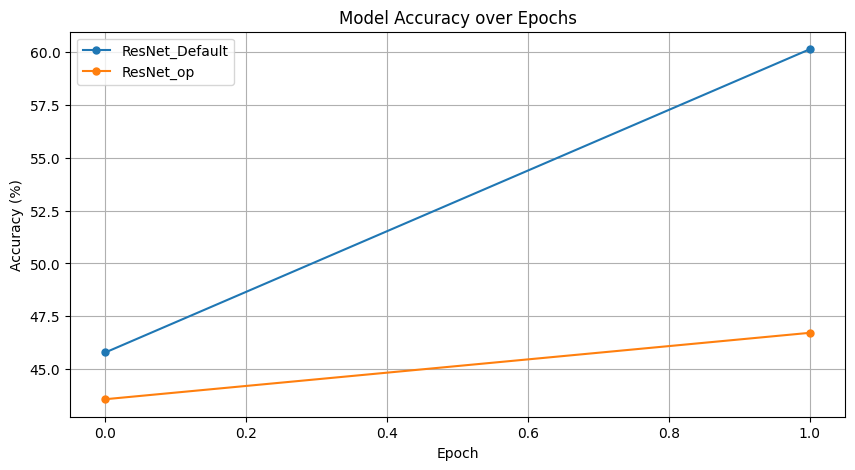

In [22]:
# Visualize the test accuracy
plt.figure(figsize=(10, 5))

plt.plot(acc_res, marker='o', linestyle='-', markersize=5, label='ResNet_Default')
plt.plot(acc_res_1, marker='o', linestyle='-', markersize=5, label='ResNet_op')

plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.grid(True)
plt.legend()
plt.show()

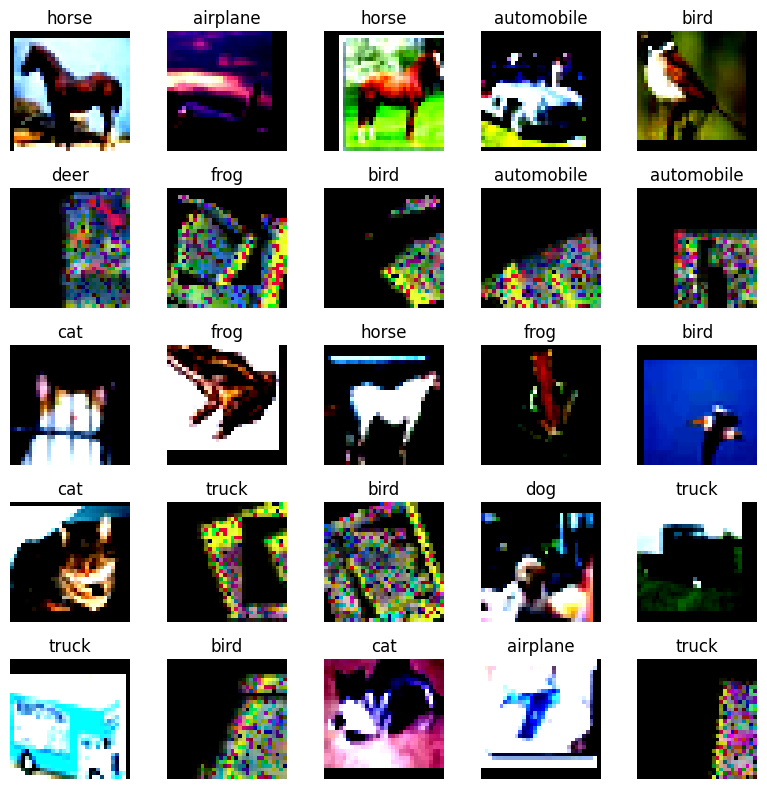

In [23]:
visualize_multiple_dataloaders([train_loader, train_loader_attacked, train_loader_attacked, train_loader_attacked, train_loader_attacked], test_loader, images_per_loader=5)

#### Poison Activation Validator

### 6. Image Restoration Module

In [ ]:
train_set_attacked = load_dataset(folder_path = default_path, dat_name = "poisoned_validate.dat")
if train_set_attacked == None or Data_Reset == True or poision_sys_reset == True:
    train_set_attacked = AugmentedDataset(
        dataset=train_set,
        perterbationset=add_set,
        attacked_ratio=1,
        overlay=True,
        alpha=0.5,
        label_attack=True,
        partial_overlay=True,
        corruption_ratio=0.2,
        attack_order="label",
        im_proc_order="overlay"
    )
    save_dataset(train_set_attacked, dat_name = "poisoned_validate.dat")

train_loader_attacked = DataLoader(dataset=train_set_attacked, batch_size=64, shuffle=True)

데이터 없음
data saved


#### 6.1 중독데이터 복원 AI 학습

##### CIFAR-10을 학습데이터로 이용

In [ ]:
auto_10 = Autoencoder().to(device)
unet_10 = UNet().to(device)

Autotest = train_model(auto_10, train_loader, net_reset= restore_sys_reset, net_name="auto_10.pt", log_name = "auto_10")
unettest = train_model(unet_10, train_loader, net_reset= restore_sys_reset, net_name="unet_10.pt", log_name = "unet_10")

##### 중독데이터를 학습데이터로 이용

In [ ]:
auto_attacked = Autoencoder().to(device)
unet_attacked = UNet().to(device)

Autotest_attaked = train_model(auto_attacked, train_loader_attacked, net_reset= restore_sys_reset, net_name="auto_attacked.pt", log_name = "auto_attacked")
unettest_attaked = train_model(unet_attacked, train_loader_attacked, net_reset= restore_sys_reset, net_name="unet_attacked.pt", log_name = "unet_attacked")

##### CIFAR-100을 학습데이터로 이용

In [ ]:
auto_100 = Autoencoder().to(device)
unet_100 = UNet().to(device)

Autotest_100 = train_model(auto_100, add_loader, net_reset= restore_sys_reset, net_name="auto_100.pt", log_name = "auto_100")
unettest_100 = train_model(unet_100, add_loader, net_reset= restore_sys_reset, net_name="unet_100.pt", log_name = "unet_100")

#### 6.2 학습결과 표출

In [ ]:
# 이미지 결과 확인 함수
def show_images(restored_data, index = 0):
    # 결과 이미지를 시각화
    o_image, o_label, p_image, p_label, r_image = restored_data.original_images, restored_data.original_labels, restored_data.poisoned_images, restored_data.poisoned_labels, restored_data.restored_images
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    
    ax[0].imshow(o_image[index].permute(1, 2, 0).cpu().detach().numpy())
    ax[0].set_title('Original')
    ax[1].imshow(p_image[index].permute(1, 2, 0).cpu().detach().numpy())
    ax[1].set_title('Poisoned')
    ax[2].imshow(r_image[index].permute(1, 2, 0).cpu().detach().numpy())
    ax[2].set_title('Recovered Output')
    
    plt.show()
    print("Original Label:", o_label[index])
    print("Poisoned Label:", p_label[index])

def multi_show(restored_data, sample = 10):
    for i in range(sample):
        label = restored_data.poisoned_labels
        index = random.randrange(1, len(label))
        show_images(restored_data, index)

#### 6.3 중독된 데이터 복구 적용

#### 복구데이터 클래스 정의

In [ ]:
class CIFAR10WithModelOutputAndLabels(Dataset):
    def __init__(self, original_images, original_labels, poisoned_images,  poisoned_labels, restored_images):
        self.original_images= original_images
        self.original_labels = original_labels        
        self.poisoned_images = poisoned_images
        self.poisoned_labels = poisoned_labels
        self.restored_images = restored_images

    def __len__(self):
        return len(self.poisoned_images)

    def __getitem__(self, idx):
        return self.original_images[idx], self.original_labels[idx], self.poisoned_images[idx], self.poisoned_labels[idx] , self.restored_images[idx]

# 이미지를 모델에 통과시키고 출력 저장하는 함수
def process_and_save_cifar10(dataloader, net_name ="default_net.pt" , output_filename="processed_cifar10_with_labels.pth"):
    """
    CIFAR-10 DataLoader에서 이미지를 처리하고, 모델의 출력과 라벨을 저장하는 함수.
    """
    os.chdir(default_path)
    model = torch.load(net_name)
    model.eval()  # 모델을 평가 모드로 설정
    os.chdir("../")

    all_original_images =[]
    all_original_labels=[]
    all_images = []
    all_outputs = []
    all_labels = []

    with torch.no_grad():  # 예측 시에는 그래디언트 계산을 하지 않음
        for data in dataloader:
            original_images, original_labels, images, labels = data
            # 이미지를 GPU로 이동 (GPU가 사용 가능하면)
            images = images.cuda() if torch.cuda.is_available() else images
            labels = labels.cuda() if torch.cuda.is_available() else labels

            # 모델을 통해 예측 결과 얻기
            outputs = model(images)

            # 결과를 리스트에 추가
            all_original_images.append(original_images)
            all_original_labels.append(original_labels)
            all_images.append(images.cpu())  # CPU로 이동하여 저장
            all_labels.append(labels.cpu())  # CPU로 이동하여 저장
            all_outputs.append(outputs.cpu())  # CPU로 이동하여 저장

    # CIFAR-10 이미지, 모델 출력, 라벨을 포함한 Dataset 생성
    combined_dataset = CIFAR10WithModelOutputAndLabels(
        torch.cat(all_original_images), torch.cat(all_original_labels), torch.cat(all_images), torch.cat(all_labels) , torch.cat(all_outputs)
    )

    os.chdir(default_path)
    # PyTorch Dataset을 저장
    torch.save(combined_dataset, output_filename)
    print(f"Processed data with labels saved to {output_filename}")
    print(os.getcwd)
    os.chdir("../")

    del model
    torch.cuda.empty_cache()
    gc.collect()


#### 복구

In [ ]:
# auto_10
if __name__ == "__main__":
    # CIFAR-10 DataLoader 로드
    cifar10_loader = train_loader_attacked

    # 학습된 unet_10 모델을 사용하여 CIFAR-10 데이터 처리 후 저장
    process_and_save_cifar10(train_loader_attacked, net_name = "auto_10.pt", output_filename="auto_10.pth")

# 저장된 파일 로드 예시
os.chdir(default_path)
s_auto_10 = torch.load("auto_10.pth")
os.chdir("../")

# 데이터, 출력, 라벨 가져오기
multi_show(s_auto_10, sample = 10)


In [ ]:
# unet_10
if __name__ == "__main__":
    # CIFAR-10 DataLoader 로드
    cifar10_loader = train_loader_attacked

    # 학습된 unet_10 모델을 사용하여 CIFAR-10 데이터 처리 후 저장
    process_and_save_cifar10(train_loader_attacked, net_name = "unet_10.pt", output_filename="unet_10.pth")

# 저장된 파일 로드 예시
os.chdir(default_path)
s_unet_10 = torch.load("unet_10.pth")
os.chdir("../")

multi_show(s_unet_10, sample = 10)

In [ ]:
# auto_attack
if __name__ == "__main__":
    # CIFAR-10 DataLoader 로드
    cifar10_loader = train_loader_attacked

    # 학습된 unet_10 모델을 사용하여 CIFAR-10 데이터 처리 후 저장
    process_and_save_cifar10(train_loader_attacked, net_name = "auto_attacked.pt", output_filename="auto_attacked.pth")

# 저장된 파일 로드 예시
os.chdir(default_path)
s_auto_attacked = torch.load("auto_attacked.pth")
os.chdir("../")

multi_show(s_auto_attacked, sample = 10)


In [ ]:
# unet_attack
if __name__ == "__main__":
    # CIFAR-10 DataLoader 로드
    cifar10_loader = train_loader_attacked

    # 학습된 unet_10 모델을 사용하여 CIFAR-10 데이터 처리 후 저장
    process_and_save_cifar10(train_loader_attacked, net_name = "unet_attacked.pt", output_filename="unet_attacked.pth")

# 저장된 파일 로드 예시
os.chdir(default_path)
s_unet_attacked = torch.load("unet_attacked.pth")
os.chdir("../")

multi_show(s_unet_attacked, sample = 10)

In [ ]:
# auto_100
if __name__ == "__main__":
    # CIFAR-10 DataLoader 로드
    cifar10_loader = train_loader_attacked

    # 학습된 unet_10 모델을 사용하여 CIFAR-10 데이터 처리 후 저장
    process_and_save_cifar10(train_loader_attacked, net_name = "auto_100.pt", output_filename="auto_100.pth")

# 저장된 파일 로드 예시
os.chdir(default_path)
s_auto_100 = torch.load("auto_100.pth")
os.chdir("../")

multi_show(s_auto_100, sample = 10)

In [ ]:
# unet_100
if __name__ == "__main__":
    # CIFAR-10 DataLoader 로드
    cifar10_loader = train_loader_attacked

    # 학습된 unet_10 모델을 사용하여 CIFAR-10 데이터 처리 후 저장
    process_and_save_cifar10(train_loader_attacked, net_name = "unet_100.pt", output_filename="unet_100.pth")

# 저장된 파일 로드 예시
os.chdir(default_path)
s_unet_100 = torch.load("unet_100.pth")
os.chdir("../")

multi_show(s_unet_100, sample = 10)


### 7. 복원 이미지 분류

In [ ]:
# ResNet50 모델 신경망 생성 및 장치에 저장
model_auto_10 = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)
model_unet_10 = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)

model_auto_attack = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)
model_unet_attack = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)

model_auto_100 = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)
model_unet_100 = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)

In [ ]:
train_loader_auto_10 = DataLoader(dataset=s_auto_10, batch_size=64, shuffle=True)

acc_auto_10 = train_and_evaluate(model_auto_10, train_loader_auto_10, test_loader, net_reset=reclass_sys_reset, net_name="auto_10_7.pt", log_name = "auto_10_7")

In [ ]:
train_loader_unet_10 = DataLoader(dataset=s_unet_10, batch_size=64, shuffle=True)

acc_unet_10 = train_and_evaluate(model_unet_10, train_loader_unet_10, test_loader, net_reset=reclass_sys_reset, net_name="unet_10_7.pt", log_name = "unet_10_7")

In [ ]:
train_loader_auto_attack = DataLoader(dataset=s_auto_attacked, batch_size=64, shuffle=True)

acc_auto_attack = train_and_evaluate(model_auto_attack, train_loader_auto_attack, test_loader, net_reset=reclass_sys_reset, net_name="auto_attacked_7.pt", log_name = "auto_attacked_7")

In [ ]:
train_loader_unet_attack = DataLoader(dataset=s_unet_attacked, batch_size=64, shuffle=True)

acc_unet_attack = train_and_evaluate(model_unet_attack, train_loader_unet_attack, test_loader, net_reset=reclass_sys_reset, net_name="unet_attacked_7.pt", log_name = "unet_attacked_7")

In [ ]:
train_loader_auto_100 = DataLoader(dataset=s_auto_100, batch_size=64, shuffle=True)

acc_auto_100 = train_and_evaluate(model_auto_100, train_loader_auto_100, test_loader, net_reset=reclass_sys_reset, net_name="auto_100_7.pt", log_name = "auto_100_7")

In [ ]:
train_loader_unet_100 = DataLoader(dataset=s_unet_10, batch_size=64, shuffle=True)

acc_unet_100 = train_and_evaluate(model_unet_100, train_loader_unet_100, test_loader, net_reset=reclass_sys_reset, net_name="unet_100_7.pt", log_name = "unet_100_7")

In [ ]:
# Visualize the test accuracy
plt.figure(figsize=(10, 5))

plt.plot(acc_res, marker='o', linestyle='-', markersize=5, label='ResNet_Default')
plt.plot(acc_res_1, marker='o', linestyle='-', markersize=5, label='Poisoned')
plt.plot(acc_auto_10, marker='x', linestyle='-', markersize=5, label='auto_10')
plt.plot(acc_unet_10, marker='x', linestyle='-', markersize=5, label='unet_10')
plt.plot(acc_auto_attack, marker='x', linestyle='-', markersize=5, label='auto_attack')
plt.plot(acc_auto_attack, marker='x', linestyle='-', markersize=5, label='unet_attack')
plt.plot(acc_auto_100, marker='x', linestyle='-', markersize=5, label='auto_100')
plt.plot(acc_unet_100, marker='x', linestyle='-', markersize=5, label='unet_100')

plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.grid(True)
plt.legend()
plt.show()

### 8. Classification Multiplied 

In [ ]:
# ResNet50 모델 신경망 생성 및 장치에 저장
model_auto_10_2x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=20).to(device)
model_unet_10_2x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=20).to(device)

model_auto_attacked_2x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=20).to(device)
model_unet_attacked_2x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=20).to(device)

model_auto_100_2x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=20).to(device)
model_unet_100_2x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=20).to(device)

In [ ]:
# ResNet50 모델 신경망 생성 및 장치에 저장
model_auto_10_3x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=30).to(device)
model_unet_10_3x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=30).to(device)

model_auto_attacked_3x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=30).to(device)
model_unet_attacked_3x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=30).to(device)

model_auto_100_3x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=30).to(device)
model_unet_100_3x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=30).to(device)

In [ ]:
# ResNet50 모델 신경망 생성 및 장치에 저장
model_auto_10_5x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=50).to(device)
model_unet_10_5x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=50).to(device)

model_auto_attacked_5x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=50).to(device)
model_unet_attacked_5x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=50).to(device)

model_auto_100_5x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=50).to(device)
model_unet_100_5x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=50).to(device)

In [ ]:
# ResNet50 모델 신경망 생성 및 장치에 저장
model_auto_10_10x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=100).to(device)
model_unet_10_10x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=100).to(device)

model_auto_attacked_10x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=100).to(device)
model_unet_attacked_10x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=100).to(device)

model_auto_100_10x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=100).to(device)
model_unet_100_10x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=100).to(device)

#### Auto_10

In [ ]:
train_loader_auto_10_2x = DataLoader(dataset=s_auto_10, batch_size=64, shuffle=True)

acc_auto_10_2x = train_and_evaluate(model_auto_10_2x, train_loader_auto_10_2x, test_loader, net_reset=(multiplier_sys_reset or M_reset_auto_10), net_name="auto_10_2x.pt", log_name = "auto_10_2x")

In [ ]:
train_loader_auto_10_3x = DataLoader(dataset=s_auto_10, batch_size=64, shuffle=True)

acc_auto_10_3x = train_and_evaluate(model_auto_10_3x, train_loader_auto_10_3x, test_loader, net_reset=(multiplier_sys_reset or M_reset_auto_10), net_name="auto_10.3x", log_name = "auto_10_3x")

In [ ]:
train_loader_auto_10_5x = DataLoader(dataset=s_auto_10, batch_size=64, shuffle=True)

acc_auto_10_5x = train_and_evaluate(model_auto_10_5x, train_loader_auto_10_5x, test_loader, net_reset=(multiplier_sys_reset or M_reset_auto_10), net_name="auto_10_5x.pt", log_name = "auto_10_5x")

In [ ]:
train_loader_auto_10_10x = DataLoader(dataset=s_auto_10, batch_size=64, shuffle=True)

acc_auto_10_10x = train_and_evaluate(model_auto_10_10x, train_loader_auto_10_10x, test_loader, net_reset=(multiplier_sys_reset or M_reset_auto_10), net_name="auto_10_10x.pt", log_name = "auto_10_10x")

In [ ]:
# Visualize the test accuracy
plt.figure(figsize=(10, 5))

plt.plot(acc_res, marker='o', linestyle='-', markersize=5, label='ResNet_Default')
plt.plot(acc_res_1, marker='o', linestyle='-', markersize=5, label='Poisoned')
plt.plot(acc_auto_10, marker='x', linestyle='-', markersize=5, label='auto_10')
plt.plot(acc_auto_10_2x, marker='+', linestyle='-', markersize=5, label='auto_10_2x')
plt.plot(acc_auto_10_3x, marker='+', linestyle='-', markersize=5, label='auto_10_3x')
plt.plot(acc_auto_10_5x, marker='+', linestyle='-', markersize=5, label='auto_10_5x')
plt.plot(acc_auto_10_10x, marker='+', linestyle='-', markersize=5, label='auto_10_10x')
# plt.plot(acc_unet_10, marker='x', linestyle='-', markersize=5, label='unet_10')
# plt.plot(acc_auto_attack, marker='x', linestyle='-', markersize=5, label='auto_attack')
# plt.plot(acc_auto_attack, marker='x', linestyle='-', markersize=5, label='unet_attack')
# plt.plot(acc_auto_100, marker='x', linestyle='-', markersize=5, label='auto_100')
# plt.plot(acc_unet_100, marker='x', linestyle='-', markersize=5, label='unet_100')

plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.grid(True)
plt.legend()
plt.show()

#### unet_10

In [ ]:
train_loader_unet_10_2x = DataLoader(dataset=s_unet_10, batch_size=64, shuffle=True)

acc_unet_10_2x = train_and_evaluate(model_unet_10_2x, train_loader_unet_10_2x, test_loader, net_reset=(multiplier_sys_reset or M_reset_unet_10), net_name="unet_10_2x.pt", log_name = "unet_10_2x")

In [ ]:
train_loader_unet_10_3x = DataLoader(dataset=s_unet_10, batch_size=64, shuffle=True)

acc_unet_10_3x = train_and_evaluate(model_unet_10_3x, train_loader_unet_10_3x, test_loader, net_reset=(multiplier_sys_reset or M_reset_unet_10), net_name="unet_10_3x.pt", log_name = "unet_10_3x")

In [ ]:
train_loader_unet_10_5x = DataLoader(dataset=s_unet_10, batch_size=64, shuffle=True)

acc_unet_10_5x = train_and_evaluate(model_unet_10_5x, train_loader_unet_10_5x, test_loader, net_reset=(multiplier_sys_reset or M_reset_unet_10), net_name="unet_10_5x.pt", log_name = "unet_10_5x")

In [ ]:
train_loader_unet_10_10x = DataLoader(dataset=s_unet_10, batch_size=64, shuffle=True)

acc_unet_10_10x = train_and_evaluate(model_unet_10_2x, train_loader_unet_10_10x, test_loader, net_reset=(multiplier_sys_reset or M_reset_unet_10), net_name="unet_10_10x.pt", log_name = "unet_10_10x")

In [ ]:
# Visualize the test accuracy
plt.figure(figsize=(10, 5))

plt.plot(acc_res, marker='o', linestyle='-', markersize=5, label='ResNet_Default')
plt.plot(acc_res_1, marker='o', linestyle='-', markersize=5, label='Poisoned')
plt.plot(acc_auto_10, marker='x', linestyle='-', markersize=5, label='auto_10')
plt.plot(acc_auto_10_2x, marker='+', linestyle='-', markersize=5, label='auto_10_2x')
plt.plot(acc_auto_10_3x, marker='+', linestyle='-', markersize=5, label='auto_10_3x')
plt.plot(acc_auto_10_5x, marker='+', linestyle='-', markersize=5, label='auto_10_5x')
plt.plot(acc_auto_10_10x, marker='+', linestyle='-', markersize=5, label='auto_10_10x')
# plt.plot(acc_unet_10, marker='x', linestyle='-', markersize=5, label='unet_10')
# plt.plot(acc_auto_attack, marker='x', linestyle='-', markersize=5, label='auto_attack')
# plt.plot(acc_auto_attack, marker='x', linestyle='-', markersize=5, label='unet_attack')
# plt.plot(acc_auto_100, marker='x', linestyle='-', markersize=5, label='auto_100')
# plt.plot(acc_unet_100, marker='x', linestyle='-', markersize=5, label='unet_100')

plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.grid(True)
plt.legend()
plt.show()

#### auto_attacked

In [ ]:
train_loader_auto_attacked_2x = DataLoader(dataset=s_auto_attacked, batch_size=64, shuffle=True)

acc_auto_attacked_2x = train_and_evaluate(model_auto_attacked_2x, train_loader_auto_attacked_2x, test_loader, net_reset=(multiplier_sys_reset or M_reset_auto_attacked), net_name="auto_attacked_2x.pt", log_name = "auto_attacked_2x")

In [ ]:
train_loader_auto_attacked_3x = DataLoader(dataset=s_auto_attacked, batch_size=64, shuffle=True)

acc_auto_attacked_3x = train_and_evaluate(model_auto_attacked_3x, train_loader_auto_attacked_3x, test_loader, net_reset=(multiplier_sys_reset or M_reset_auto_attacked), net_name="auto_attacked_3x.pt", log_name = "auto_attacked_3x")

In [ ]:
train_loader_auto_attacked_5x = DataLoader(dataset=s_auto_attacked, batch_size=64, shuffle=True)

acc_auto_attacked_5x = train_and_evaluate(model_auto_attacked_5x, train_loader_auto_attacked_5x, test_loader, net_reset=(multiplier_sys_reset or M_reset_auto_attacked), net_name="auto_attacked_5x.pt", log_name = "auto_attacked_5x")

In [ ]:
train_loader_auto_attacked_10x = DataLoader(dataset=s_auto_attacked, batch_size=64, shuffle=True)

acc_auto_attacked_10x = train_and_evaluate(model_auto_attacked_2x, train_loader_auto_attacked_10x, test_loader, net_reset=(multiplier_sys_reset or M_reset_auto_attacked), net_name="auto_attacked_10x.pt", log_name = "auto_attacked_10x")

In [ ]:
# Visualize the test accuracy
plt.figure(figsize=(10, 5))

plt.plot(acc_res, marker='o', linestyle='-', markersize=5, label='ResNet_Default')
plt.plot(acc_res_1, marker='o', linestyle='-', markersize=5, label='Poisoned')
plt.plot(acc_auto_attack, marker='x', linestyle='-', markersize=5, label='auto_attacked')
plt.plot(acc_auto_attacked_2x, marker='+', linestyle='-', markersize=5, label='auto_attacked_2x')
plt.plot(acc_auto_attacked_3x, marker='+', linestyle='-', markersize=5, label='auto_attacked_3x')
plt.plot(acc_auto_attacked_5x, marker='+', linestyle='-', markersize=5, label='auto_attacked_5x')
plt.plot(acc_auto_attacked_10x, marker='+', linestyle='-', markersize=5, label='auto_attacked_10x')
# plt.plot(acc_unet_10, marker='x', linestyle='-', markersize=5, label='unet_10')
# plt.plot(acc_auto_attack, marker='x', linestyle='-', markersize=5, label='auto_attack')
# plt.plot(acc_auto_attack, marker='x', linestyle='-', markersize=5, label='unet_attack')
# plt.plot(acc_auto_100, marker='x', linestyle='-', markersize=5, label='auto_100')
# plt.plot(acc_unet_100, marker='x', linestyle='-', markersize=5, label='unet_100')

plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.grid(True)
plt.legend()
plt.show()

#### unet_attacked

In [ ]:
train_loader_unet_attacked_2x = DataLoader(dataset=s_unet_attacked, batch_size=64, shuffle=True)

acc_unet_attacked_2x = train_and_evaluate(model_unet_attacked_2x, train_loader_unet_attacked_2x, test_loader, net_reset=(multiplier_sys_reset or M_reset_unet_attacked), net_name="unet_attacked_2x.pt", log_name = "unet_attacked_2x")

In [ ]:
train_loader_unet_attacked_3x = DataLoader(dataset=s_unet_attacked, batch_size=64, shuffle=True)

acc_unet_attacked_3x = train_and_evaluate(model_unet_attacked_3x, train_loader_unet_attacked_3x, test_loader, net_reset=(multiplier_sys_reset or M_reset_unet_attacked), net_name="unet_attacked_3x.pt", log_name = "unet_attacked_3x")

In [ ]:
train_loader_unet_attacked_5x = DataLoader(dataset=s_unet_attacked, batch_size=64, shuffle=True)

acc_unet_attacked_5x = train_and_evaluate(model_unet_attacked_5x, train_loader_unet_attacked_5x, test_loader, net_reset=(multiplier_sys_reset or M_reset_unet_attacked), net_name="unet_attacked_5x.pt", log_name = "unet_attacked_5x")

In [ ]:
train_loader_unet_attacked_10x = DataLoader(dataset=s_unet_attacked, batch_size=64, shuffle=True)

acc_unet_attacked_10x = train_and_evaluate(model_unet_attacked_2x, train_loader_unet_attacked_10x, test_loader, net_reset=(multiplier_sys_reset or M_reset_unet_attacked), net_name="unet_attacked_10x.pt", log_name = "unet_attacked_10x")

In [ ]:
# Visualize the test accuracy
plt.figure(figsize=(10, 5))

plt.plot(acc_res, marker='o', linestyle='-', markersize=5, label='ResNet_Default')
plt.plot(acc_res_1, marker='o', linestyle='-', markersize=5, label='Poisoned')
plt.plot(acc_unet_attack, marker='x', linestyle='-', markersize=5, label='unet_attacked')
plt.plot(acc_unet_attacked_2x, marker='+', linestyle='-', markersize=5, label='unet_attacked_2x')
plt.plot(acc_unet_attacked_3x, marker='+', linestyle='-', markersize=5, label='unet_attacked_3x')
plt.plot(acc_unet_attacked_5x, marker='+', linestyle='-', markersize=5, label='unet_attacked_5x')
plt.plot(acc_unet_attacked_10x, marker='+', linestyle='-', markersize=5, label='unet_attacked_10x')
# plt.plot(acc_unet_10, marker='x', linestyle='-', markersize=5, label='unet_10')
# plt.plot(acc_auto_attack, marker='x', linestyle='-', markersize=5, label='auto_attack')
# plt.plot(acc_auto_attack, marker='x', linestyle='-', markersize=5, label='unet_attack')
# plt.plot(acc_auto_100, marker='x', linestyle='-', markersize=5, label='auto_100')
# plt.plot(acc_unet_100, marker='x', linestyle='-', markersize=5, label='unet_100')

plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.grid(True)
plt.legend()
plt.show()

#### auto_100

In [ ]:
train_loader_auto_100_2x = DataLoader(dataset=s_auto_100, batch_size=64, shuffle=True)

acc_auto_100_2x = train_and_evaluate(model_auto_100_2x, train_loader_auto_100_2x, test_loader, net_reset=(multiplier_sys_reset or M_reset_auto_100), net_name="auto_100_2x.pt", log_name = "auto_100_2x")

In [ ]:
train_loader_auto_100_3x = DataLoader(dataset=s_auto_100, batch_size=64, shuffle=True)

acc_auto_100_3x = train_and_evaluate(model_auto_100_3x, train_loader_auto_100_3x, test_loader, net_reset=(multiplier_sys_reset or M_reset_auto_100), net_name="auto_100_3x.pt", log_name = "auto_100_3x")

In [ ]:
train_loader_auto_100_5x = DataLoader(dataset=s_auto_100, batch_size=64, shuffle=True)

acc_auto_100_5x = train_and_evaluate(model_auto_100_5x, train_loader_auto_100_5x, test_loader, net_reset=(multiplier_sys_reset or M_reset_auto_100), net_name="auto_100_5x.pt", log_name = "auto_100_5x")

In [ ]:
train_loader_auto_100_10x = DataLoader(dataset=s_auto_100, batch_size=64, shuffle=True)

acc_auto_100_10x = train_and_evaluate(model_auto_100_2x, train_loader_auto_100_10x, test_loader, net_reset=(multiplier_sys_reset or M_reset_unet_10), net_name="auto_100_10x.pt", log_name = "auto_100_10x")

In [ ]:
# Visualize the test accuracy
plt.figure(figsize=(10, 5))

plt.plot(acc_res, marker='o', linestyle='-', markersize=5, label='ResNet_Default')
plt.plot(acc_res_1, marker='o', linestyle='-', markersize=5, label='Poisoned')
plt.plot(acc_auto_100, marker='x', linestyle='-', markersize=5, label='auto_100')
plt.plot(acc_auto_100_2x, marker='+', linestyle='-', markersize=5, label='auto_100_2x')
plt.plot(acc_auto_100_3x, marker='+', linestyle='-', markersize=5, label='auto_100_3x')
plt.plot(acc_auto_100_5x, marker='+', linestyle='-', markersize=5, label='auto_100_5x')
plt.plot(acc_auto_100_10x, marker='+', linestyle='-', markersize=5, label='auto_100_10x')
# plt.plot(acc_unet_10, marker='x', linestyle='-', markersize=5, label='unet_10')
# plt.plot(acc_auto_attack, marker='x', linestyle='-', markersize=5, label='auto_attack')
# plt.plot(acc_auto_attack, marker='x', linestyle='-', markersize=5, label='unet_attack')
# plt.plot(acc_auto_100, marker='x', linestyle='-', markersize=5, label='auto_100')
# plt.plot(acc_unet_100, marker='x', linestyle='-', markersize=5, label='unet_100')

plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.grid(True)
plt.legend()
plt.show()

#### unet_100

In [ ]:
train_loader_unet_100_2x = DataLoader(dataset=s_unet_100, batch_size=64, shuffle=True)

acc_unet_100_2x = train_and_evaluate(model_unet_100_2x, train_loader_unet_100_2x, test_loader, net_reset=(multiplier_sys_reset or M_reset_unet_100), net_name="unet_100_2x.pt", log_name = "unet_100_2x")

In [ ]:
train_loader_unet_100_3x = DataLoader(dataset=s_unet_100, batch_size=64, shuffle=True)

acc_unet_100_3x = train_and_evaluate(model_unet_100_3x, train_loader_unet_100_3x, test_loader, net_reset=(multiplier_sys_reset or M_reset_unet_100), net_name="unet_100_3x.pt", log_name = "unet_100_3x")

In [ ]:
train_loader_unet_100_5x = DataLoader(dataset=s_unet_100, batch_size=64, shuffle=True)

acc_unet_100_5x = train_and_evaluate(model_unet_100_5x, train_loader_unet_100_5x, test_loader, net_reset=(multiplier_sys_reset or M_reset_unet_100), net_name="unet_100_5x.pt", log_name = "unet_100_5x")

In [ ]:
train_loader_unet_100_10x = DataLoader(dataset=s_unet_100, batch_size=64, shuffle=True)

acc_unet_100_10x = train_and_evaluate(model_unet_100_2x, train_loader_unet_100_10x, test_loader, net_reset=(multiplier_sys_reset or M_reset_unet_100), net_name="unet_100_10x.pt", log_name = "unet_100_10x")

In [ ]:
# Visualize the test accuracy
plt.figure(figsize=(10, 5))

plt.plot(acc_res, marker='o', linestyle='-', markersize=5, label='ResNet_Default')
plt.plot(acc_res_1, marker='o', linestyle='-', markersize=5, label='Poisoned')
plt.plot(acc_unet_100, marker='x', linestyle='-', markersize=5, label='unet_100')
plt.plot(acc_unet_100_2x, marker='+', linestyle='-', markersize=5, label='unet_100_2x')
plt.plot(acc_unet_100_3x, marker='+', linestyle='-', markersize=5, label='unet_100_3x')
plt.plot(acc_unet_100_5x, marker='+', linestyle='-', markersize=5, label='unet_100_5x')
plt.plot(acc_unet_100_10x, marker='+', linestyle='-', markersize=5, label='unet_100_10x')
# plt.plot(acc_unet_10, marker='x', linestyle='-', markersize=5, label='unet_10')
# plt.plot(acc_auto_attack, marker='x', linestyle='-', markersize=5, label='auto_attack')
# plt.plot(acc_auto_attack, marker='x', linestyle='-', markersize=5, label='unet_attack')
# plt.plot(acc_auto_100, marker='x', linestyle='-', markersize=5, label='auto_100')
# plt.plot(acc_unet_100, marker='x', linestyle='-', markersize=5, label='unet_100')

plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.grid(True)
plt.legend()
plt.show()